
<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to predict if a customer pays or deafults a loan.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [ ]:
import wget
loan_train = wget.download("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv")

### Load Data From CSV File


In [2]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
# Remove redundant columns
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [4]:
df.shape

(346, 8)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


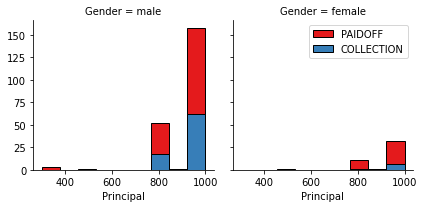

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

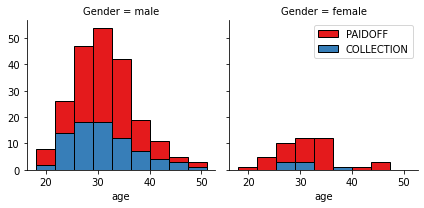

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


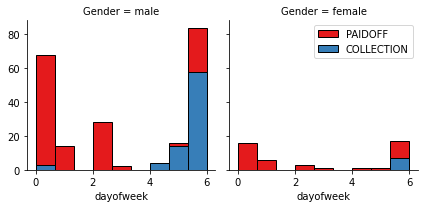

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical variables to binary variables and append them to the feature Data Frame


In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


#### One hot encoding 'terms' variable

In [16]:
df.groupby(['terms'])['loan_status'].value_counts(normalize=True)

terms  loan_status
7      PAIDOFF        1.000000
15     PAIDOFF        0.770270
       COLLECTION     0.229730
30     PAIDOFF        0.717391
       COLLECTION     0.282609
Name: loan_status, dtype: float64

In [17]:
Feature = pd.concat([Feature, pd.get_dummies(df['terms'], prefix='term')], axis=1)
Feature.drop(['term_7', 'terms'], axis=1, inplace=True)
Feature.head()

,Principal,age,Gender,weekend,Bechalor,High School or Below,college,term_15,term_30
0,1000,45,0,0,0,1,0,0,1
1,1000,33,1,0,1,0,0,0,1
2,1000,27,0,0,0,0,1,1,0
3,1000,28,1,1,0,0,1,0,1
4,1000,29,0,1,0,0,1,0,1


### Feature Selection


Let's define feature sets, X:


In [18]:
X = Feature
X[0:5]

,Principal,age,Gender,weekend,Bechalor,High School or Below,college,term_15,term_30
0,1000,45,0,0,0,1,0,0,1
1,1000,33,1,0,1,0,0,0,1
2,1000,27,0,0,0,0,1,1,0
3,1000,28,1,1,0,0,1,0,1
4,1000,29,0,1,0,0,1,0,1


What are our lables?


In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [20]:
# Label loan status values to 0 and 1
from sklearn.preprocessing import LabelEncoder

label_model = LabelEncoder()
y = label_model.fit_transform(y)

In [21]:
print(y.shape)
y[0:5]

(346,)


array([1, 1, 1, 1, 1])

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [22]:
standardScaler_model = preprocessing.StandardScaler().fit(X)
X = standardScaler_model.transform(X)
X[0:5]

array([[ 0.51578458,  2.33152555, -0.42056004, -1.20577805, -0.38170062,
         1.13639374, -0.86968108, -0.86456622,  0.93831486],
       [ 0.51578458,  0.34170148,  2.37778177, -1.20577805,  2.61985426,
        -0.87997669, -0.86968108, -0.86456622,  0.93831486],
       [ 0.51578458, -0.65321055, -0.42056004, -1.20577805, -0.38170062,
        -0.87997669,  1.14984679,  1.1566494 , -1.06574034],
       [ 0.51578458, -0.48739188,  2.37778177,  0.82934003, -0.38170062,
        -0.87997669,  1.14984679, -0.86456622,  0.93831486],
       [ 0.51578458, -0.3215732 , -0.42056004,  0.82934003, -0.38170062,
        -0.87997669,  1.14984679, -0.86456622,  0.93831486]])

# Classification



Let's build models on each of the following algorithms and see how each of them compare on the final test set:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression


In [23]:
# Spliting training data to train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, shuffle=True, random_state=45)

In [24]:
print(x_train.shape,'------',y_train.shape)
print(x_test.shape, '------', y_test.shape)

(231, 9) ------ (231,)
(115, 9) ------ (115,)


# K Nearest Neighbor(KNN)



In [25]:
# Let's find best 'k' value by building multiple models with different k's and plotting metric scores

from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

k = 15

f1_scores = []
acc_scores = []

for i in range(1,k):
    KNN_classifier = KNeighborsClassifier(n_neighbors= i).fit(x_train, y_train)
    y_pred = KNN_classifier.predict(x_test)
    
    acc_scores.append(metrics.accuracy_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test, y_pred))

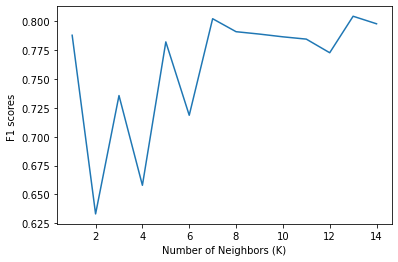

In [26]:
plt.plot(range(1,k), f1_scores)
plt.ylabel('F1 scores ')
plt.xlabel('Number of Neighbors (K)')
plt.show()

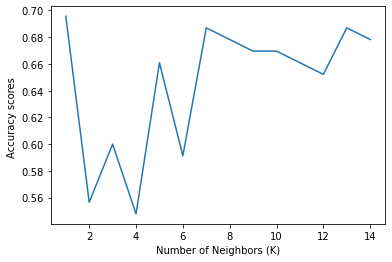

In [27]:
plt.plot(range(1,k), acc_scores)
plt.ylabel('Accuracy scores ')
plt.xlabel('Number of Neighbors (K)')
plt.show()

In [28]:
# Best model, choosing k=7
KNN_best_model = KNeighborsClassifier(n_neighbors= 7).fit(X, y)

# Decision Tree


In [29]:
# Implementing the same as above in finding best hyper parameters by using GridSearchCV
# We are using max_depth and min_samples_leaf as our hyper parameters and build multiple DT models with each combination

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {'max_depth':[2,3,4,5], 'min_samples_leaf':[5,10,20,30,40,50,60]}
DT_model = DecisionTreeClassifier(criterion='entropy')
clf_dt_model = GridSearchCV(DT_model, param_grid=params, cv=3, scoring='f1', return_train_score=True)

clf_dt_model.fit(X, y)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [5, 10, 20, 30, 40, 50, 60]},
             return_train_score=True, scoring='f1')

In [30]:
# Best model is found out for us with best scoring metric
clf_dt_model.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=5)

In [31]:
# Build the final DT model with the above params
best_dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=5)
best_dt_model.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=5)

# Support Vector Machine


In [32]:
# Same as we did above but here hyper params differ for SVC
# We are tuning it on kernels and 'C' values for SVC

from sklearn.svm import SVC

params = {'kernel':('linear','rbf'), 'C':[5,1,0.1,0.01,0.001,0.0001,0.00001, 0.000001]}
svc_model = GridSearchCV(SVC(), param_grid=params, cv=3, scoring='f1')

svc_model.fit(X,y)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [5, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06],
                         'kernel': ('linear', 'rbf')},
             scoring='f1')

In [33]:
# Best model is found out
svc_model.best_estimator_

SVC(C=0.1)

In [34]:
# Building new model 
best_svc_model = SVC(C=0.1)
best_svc_model.fit(X,y)

SVC(C=0.1)

# Logistic Regression


In [35]:
# Hyper params used for Logistic regression are 'C' and tolerance values

from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(solver='liblinear')
params = {'C':[5, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001], 'tol':[0.01, 0.001, 0.0001, 0.00001, 0.000001]}
clf_log_model = GridSearchCV(log_model, param_grid=params, cv=3, scoring='f1')

clf_log_model.fit(X,y)

GridSearchCV(cv=3, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [5, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'tol': [0.01, 0.001, 0.0001, 1e-05, 1e-06]},
             scoring='f1')

In [36]:
clf_log_model.best_estimator_

LogisticRegression(C=0.0001, solver='liblinear', tol=0.001)

In [37]:
# Building best model as per grid search
best_log_model = LogisticRegression(C=0.0001, solver='liblinear', tol=0.001)
best_log_model.fit(X,y)

LogisticRegression(C=0.0001, solver='liblinear', tol=0.001)

# Model Evaluation using Test set


In [38]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [ ]:
loan_test = wget.download("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv")

### Load Test set for evaluation


In [39]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [40]:
# We perform all the pre-processing we did on train data to test data as well to maintain consistency
# This way model knows what to do with the values

test_df = test_df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)

test_Feature = pd.concat([test_Feature, pd.get_dummies(test_df['terms'], prefix='term')], axis=1)
test_Feature.drop(['term_7', 'terms'], axis=1, inplace=True)

In [41]:
test_Feature.head()

,Principal,age,Gender,weekend,Bechalor,High School or Below,college,term_15,term_30
0,1000,50,1,0,1,0,0,0,1
1,300,35,0,1,0,0,0,0,0
2,1000,43,1,1,0,1,0,0,1
3,1000,26,0,1,0,0,1,0,1
4,800,29,0,1,1,0,0,1,0


In [42]:
# We use same standard scaler model we used as the one on training data
test_X = standardScaler_model.transform(test_Feature)

In [44]:
test_X[0:5]

array([[ 0.51578458,  3.16061891,  2.37778177, -1.20577805,  2.61985426,
        -0.87997669, -0.86968108, -0.86456622,  0.93831486],
       [-5.89052444,  0.67333883, -0.42056004,  0.82934003, -0.38170062,
        -0.87997669, -0.86968108, -0.86456622, -1.06574034],
       [ 0.51578458,  1.9998882 ,  2.37778177,  0.82934003, -0.38170062,
         1.13639374, -0.86968108, -0.86456622,  0.93831486],
       [ 0.51578458, -0.81902922, -0.42056004,  0.82934003, -0.38170062,
        -0.87997669,  1.14984679, -0.86456622,  0.93831486],
       [-1.31458942, -0.3215732 , -0.42056004,  0.82934003,  2.61985426,
        -0.87997669, -0.86968108,  1.1566494 , -1.06574034]])

In [45]:
# Get original y values
test_y = test_df['loan_status'].values
test_y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [46]:
# We use the same label encoder as the one used on training data to maintain consistency 
test_y = label_model.transform(test_y)

In [47]:
# KNN scores
knn_y_pred = KNN_best_model.predict(test_X)

KNN_Jacard = jaccard_score(test_y, knn_y_pred)
KNN_f1 = f1_score(test_y, knn_y_pred, average='weighted')

In [48]:
# DT scores
dt_y_pred = best_dt_model.predict(test_X)

dt_jacard = jaccard_score(test_y, dt_y_pred)
dt_f1 = f1_score(test_y, dt_y_pred, average='weighted')

In [49]:
# SVC scores
svc_y_pred = best_svc_model.predict(test_X)

svc_jaccard = jaccard_score(test_y, svc_y_pred)
svc_f1 = f1_score(test_y, svc_y_pred, average='weighted')

In [50]:
# LogReg scores
lr_y_pred = best_log_model.predict(test_X)
lr_y_proba = best_log_model.predict_proba(test_X)

lr_jaccard = jaccard_score(test_y, lr_y_pred)
lr_f1 = f1_score(test_y, lr_y_pred, average='weighted')
lr_log = log_loss(test_y, lr_y_proba)

In [51]:
# Building the final report
report = pd.DataFrame({'Algorithm':['KNN','Decision Tree','SVM','Logistic Regression'], \
                      'Jaccard':[KNN_Jacard,dt_jacard,svc_jaccard,lr_jaccard], \
                      'F1-score':[KNN_f1,dt_f1,svc_f1,lr_f1], \
                      'Log Loss':['NA','NA','NA', lr_log]})
report.head()

,Algorithm,Jaccard,F1-score,Log Loss
0,KNN,0.660377,0.615152,NA
1,Decision Tree,0.740741,0.630418,NA
2,SVM,0.740741,0.630418,NA
3,Logistic Regression,0.784314,0.742704,0.689962


Out of all the models, Logistic regression was able to get the best results on the test data. 